<a href="https://colab.research.google.com/github/KeeganCadiz/Prob-Stats/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from imageio import *
import torch
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision.models import *
from torchvision.datasets import MNIST,KMNIST,FashionMNIST
from skimage.util import montage

In [2]:
!pip install wandb
import wandb as wb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00


In [3]:
def plot(x):  # if x is a tensor, convert to numpy array, then plot a greyscale image
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

In [4]:
def montage_plot(x):  # addes a 1 pixel border, then creates a montage using plot
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [5]:
b = 1000

def get_batch(mode):  # randomly picks a start r, then slides out a batch of inputs x, and labels y
    if mode == "train":
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y


## MNIST
    

### Load Data

In [6]:
# #MNIST
train_set = MNIST('./data', train=True, download=True)
test_set  = MNIST('./data', train=False, download=True)

#KMNIST
# train_set = KMNIST('./data', train=True, download=True)
# test_set =  KMNIST('./data', train=False, download=True)

# Fashion MNIST
# train_set = FashionMNIST('./data', train=True, download=True)
# test_set =  FashionMNIST('./data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 493193409.70it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103446365.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 205444891.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21405088.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
X = train_set.data.numpy()  # converts training/testing data from pytorch tensor to numpy array
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()

X = X[:,None,:,:]/255 # set pixel values between 0-1 (greyscale)
X_test = X_test[:,None,:,:]/255

In [8]:
X.shape

(60000, 1, 28, 28)

In [9]:
Y[50000]

3

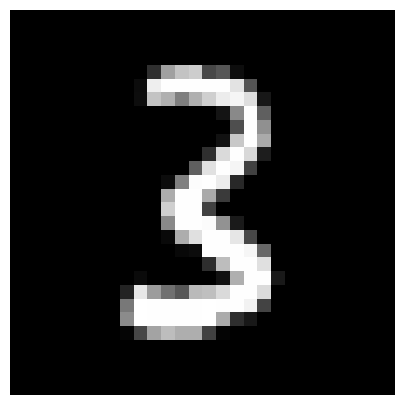

In [10]:
plot(X[50000,0,:,:])  # example #50,000 in training set

In [11]:
Y[100]

5

In [12]:
X.shape

(60000, 1, 28, 28)

In [13]:
X[0:25,0,:,:].shape

(25, 28, 28)

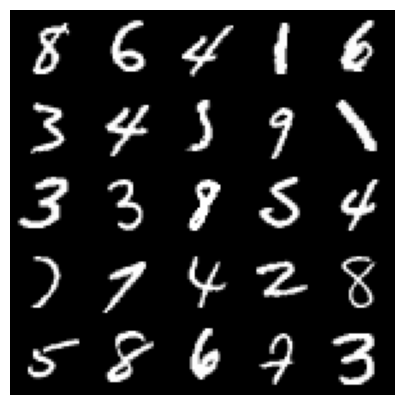

In [14]:
montage_plot(X[125:150,0,:,:])  # images 125-150

In [15]:
X.shape[0]

60000

In [16]:
X_test.shape

(10000, 1, 28, 28)

In [17]:
X.shape[0]

60000

In [18]:
X_test.shape[0]

10000

In [19]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data): # same as GPU but with gradient computation enabled
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [20]:
X = GPU_data(X)
Y = GPU_data(Y)
X_test = GPU_data(X_test)
Y_test = GPU_data(Y_test)

In [21]:
X = X.reshape(X.shape[0],784) # flattens the images from 28x28 pixels to a single 784 size vector
X_test = X_test.reshape(X_test.shape[0],784)

In [22]:
X.shape

torch.Size([60000, 784])


### Classifier


In [23]:
x,y = get_batch('train')  # gets a bunch of training data

In [24]:
x.shape

torch.Size([1000, 784])

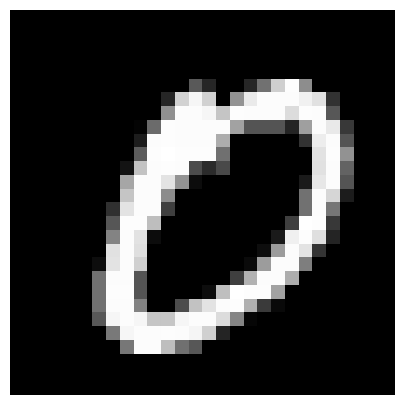

In [25]:
plot(x[0].reshape(28,28)) # sets size back to 28x28 pixels so we can view them

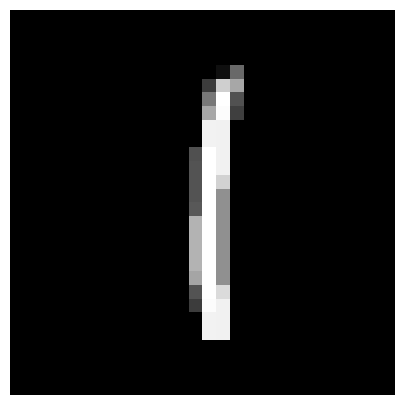

In [26]:
plot(x[1].reshape(28,28))

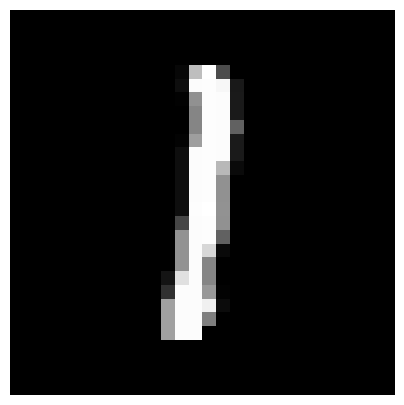

In [27]:
plot(x[2].reshape(28,28))

In [28]:
y[:10]  # first three numbers are 0, 1, 1, as shown above

tensor([0., 1., 1., 9., 2., 4., 3., 5., 4., 9.], device='cuda:0')

In [29]:
W = GPU(np.random.randn(784,10))  # 784 input features, outputs one of 10 numbers 0-9

In [30]:
x.shape, W.shape

(torch.Size([1000, 784]), torch.Size([784, 10]))

In [31]:
torch.matmul(x,W).shape

torch.Size([1000, 10])

In [32]:
(x@W).shape

torch.Size([1000, 10])

In [33]:
%%timeit
x@W # measures average timeto compute the matrix multiplication

27.6 µs ± 4.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
x@W

tensor([[ -3.3192,  18.3855,   0.2390,  ...,  -6.8910,  15.6736, -16.4905],
        [  5.9244,   7.6876,   3.5011,  ...,   7.9439,   1.6506,   1.5030],
        [  2.5536,  -1.5272,   6.4235,  ...,  -2.0932,  10.0070,   4.1799],
        ...,
        [ 10.9872,   3.5770, -13.8632,  ..., -12.9128,  -3.6271, -11.5491],
        [ -4.3958,   5.8272,  10.4945,  ...,   2.0241,  -2.9692, -22.4189],
        [ -3.9044,   5.7365,   8.8263,  ...,   2.4657,   3.6690,   7.2035]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [35]:
y2 = x@W

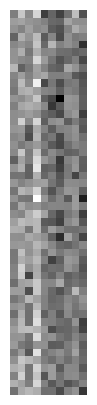

In [36]:
plot(y2[:50]) # random pixels because y2 still contains raw score tensors

In [37]:
y

tensor([0., 1., 1., 9., 2., 4., 3., 5., 4., 9., 5., 2., 6., 3., 7., 4., 8., 9.,
        9., 2., 0., 6., 1., 4., 2., 0., 3., 6., 4., 3., 5., 0., 6., 5., 7., 9.,
        8., 7., 9., 9., 0., 8., 1., 0., 2., 7., 3., 9., 4., 8., 5., 6., 6., 3.,
        7., 3., 8., 2., 5., 3., 0., 1., 6., 8., 8., 5., 9., 1., 4., 7., 1., 3.,
        9., 0., 0., 2., 4., 6., 8., 2., 9., 1., 1., 3., 4., 0., 0., 9., 5., 3.,
        1., 8., 5., 5., 4., 2., 0., 4., 7., 3., 6., 9., 0., 1., 1., 3., 7., 9.,
        0., 6., 6., 7., 8., 1., 9., 1., 5., 8., 4., 9., 7., 3., 6., 1., 0., 2.,
        8., 9., 1., 4., 7., 1., 7., 0., 1., 0., 3., 3., 2., 0., 3., 0., 1., 5.,
        0., 2., 0., 2., 7., 8., 8., 4., 4., 7., 9., 6., 3., 8., 8., 0., 4., 8.,
        7., 1., 2., 7., 5., 8., 6., 3., 3., 4., 6., 1., 9., 0., 4., 2., 6., 4.,
        9., 1., 0., 0., 2., 3., 5., 8., 5., 3., 1., 0., 3., 6., 3., 5., 9., 1.,
        7., 2., 8., 4., 7., 2., 2., 7., 2., 8., 5., 9., 7., 8., 9., 3., 2., 2.,
        1., 9., 3., 6., 0., 1., 1., 8., 

In [38]:
y.shape

torch.Size([1000])

In [39]:
def one_hot(y): # converts batch labels y into one hot encoded format
    y2 = GPU_data(torch.zeros((y.shape[0],10)))
    for i in range(y.shape[0]):
        y2[i,int(y[i])] = 1
    return y2

In [40]:
one_hot(y)

<ipython-input-19-c3d856de2607>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [41]:
torch.argmax(y2,1)

tensor([3, 7, 8, 3, 3, 3, 3, 0, 4, 3, 2, 3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3,
        3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 1, 3, 3, 2, 3, 3, 3, 2, 3, 0, 3, 1, 3, 1,
        3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 4, 3, 3, 3, 7, 3, 1, 0, 1,
        3, 8, 3, 3, 3, 1, 3, 7, 3, 2, 3, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 7,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 0, 1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 3, 3, 1, 2,
        3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0,
        3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3,
        3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 4, 8, 3, 8, 3, 3,
        3, 3, 3, 1, 3, 3, 1, 7, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 9, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 7, 3, 0, 3, 3,
        3, 3, 2, 3, 3, 0, 1, 8, 3, 8, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 0, 3, 8, 1, 9, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 8, 3, 3, 3, 1, 3,

In [42]:
torch.sum(y == torch.argmax(y2,1))/b  # calculates accuracy of the model's predictions

tensor(0.0780, device='cuda:0')

In [43]:
X.shape

torch.Size([60000, 784])

In [44]:
X@W

tensor([[ -2.3393,  21.0873,  12.2395,  ...,  -4.6045,   9.3225, -28.1583],
        [ 11.9470,  11.4064,  -4.9731,  ...,  -6.5994,   5.6316, -22.8614],
        [  6.9269,  -7.9607,  -5.4491,  ...,   1.2857,   1.9657, -14.9958],
        ...,
        [ -1.5619,   9.5661,   4.0781,  ...,   4.0405,   2.9271, -14.0947],
        [  3.3244,   3.2497,   9.2155,  ...,   3.2417,   8.3392, -12.5477],
        [ -0.3131,   5.5914, -10.2169,  ...,  -2.7059,   1.8697, -13.1458]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [45]:
torch.argmax(X@W,1) # computes class predictions for entire dataset

tensor([1, 3, 3,  ..., 1, 3, 3], device='cuda:0')

In [46]:
Y

tensor([5., 0., 4.,  ..., 5., 6., 8.], device='cuda:0')

In [47]:
torch.sum(torch.argmax(X@W,1) == Y)/60000 # compares predictions from line 45 with the true labels 'Y'. total predictions/total examples = accuracy

tensor(0.0652, device='cuda:0')

In [48]:
X@W

tensor([[ -2.3393,  21.0873,  12.2395,  ...,  -4.6045,   9.3225, -28.1583],
        [ 11.9470,  11.4064,  -4.9731,  ...,  -6.5994,   5.6316, -22.8614],
        [  6.9269,  -7.9607,  -5.4491,  ...,   1.2857,   1.9657, -14.9958],
        ...,
        [ -1.5619,   9.5661,   4.0781,  ...,   4.0405,   2.9271, -14.0947],
        [  3.3244,   3.2497,   9.2155,  ...,   3.2417,   8.3392, -12.5477],
        [ -0.3131,   5.5914, -10.2169,  ...,  -2.7059,   1.8697, -13.1458]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [49]:
W.shape

torch.Size([784, 10])

In [50]:
W[:,0].shape

torch.Size([784])

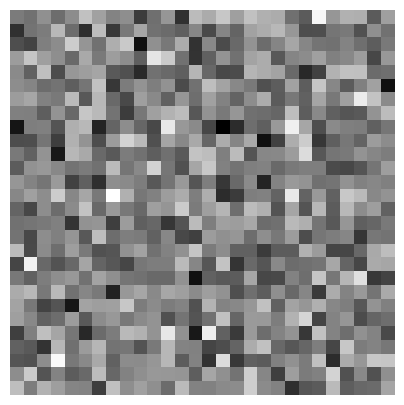

In [51]:
plot(W[:,0].reshape(28,28)) # guess

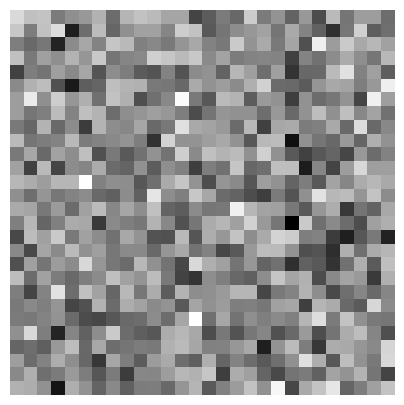

In [52]:
plot(W[:,2].reshape(28,28)) # guess

In [53]:
W.shape

torch.Size([784, 10])

In [54]:
(W.T).shape

torch.Size([10, 784])

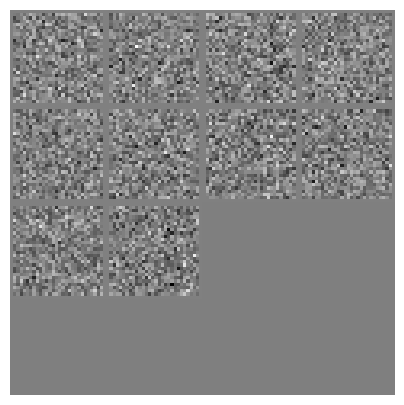

In [55]:
montage_plot((W.T).reshape(10,28,28).cpu().detach().numpy())  # keep guessing

In [56]:
def softmax(x): # converts raw logits into probabilities in range 0-1, and sum to 1 across classes for each input
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [57]:
def cross_entropy(outputs, labels): # calculates negative log probabilities from softmax output at the indices of the labels. This penalizes deviation from true class labels
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]

In [58]:
def acc(out,y): # evaluates accuracy
    return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [59]:
def get_batch(mode):  # same as before but uses dynamic batch sizes
    b = c.b
    if mode == "train":
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [60]:
def model(x,w): # addes weight

    return x@w[0]

In [61]:
def gradient_step(w): # gradient descent step

    w[0].data = w[0].data - c.L*w[0].grad.data

    w[0].grad.data.zero_()

In [62]:
def make_plots(): # logs training and testing accuracy to WandB for monitoring

    acc_train = acc(model(x,w),y)

    xt,yt = get_batch('test')

    acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train, "acc_test": acc_test})

In [63]:
def Truncated_Normal(size):

    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2)
    u2 = torch.rand(size)
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2)

    return z

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-19-c3d856de2607>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))


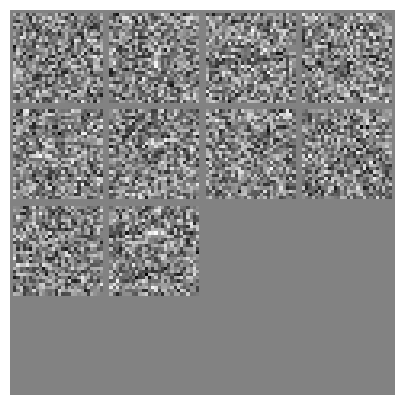

acc_test,▁▂▂▃▄▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇██▇▇██
acc_train,▁▂▃▃▄▄▅▅▅▆▅▆▆▆▆▆▅▆▆▆▆▆▆▇▆▇▆▇▆▇▇▇▇▇▇█████
acc_test,0.55859
acc_train,0.51562


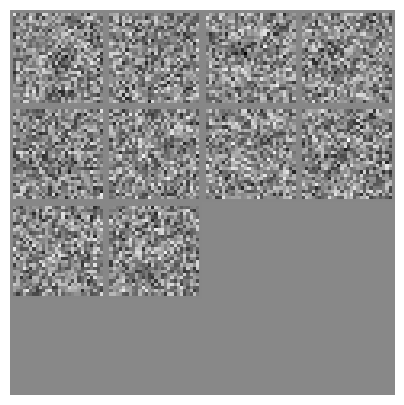

acc_test,▁▁▂▃▄▃▄▄▅▅▅▅▆▅▆▅▅▇▆▇▇▇▇▆▇█▇▇▇▆█▇▇▇██▇▇██
acc_train,▁▁▂▂▃▄▄▄▄▅▄▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇
acc_test,0.66699
acc_train,0.6543


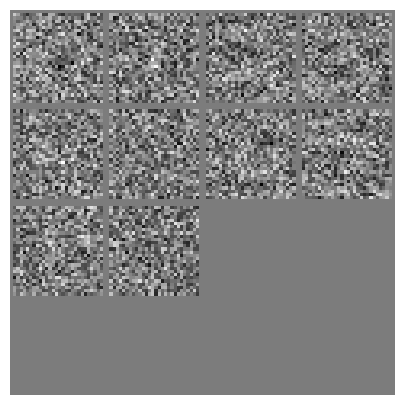

In [64]:
for run in range(3):  # runs the experiment multiple times using WandB

    wb.init(project="Simple_Linear_SGD_123");
    c = wb.config

    c.L = 0.1
    c.b = 1024
    c.epochs = 10000

    w = [GPU(Truncated_Normal((784,10)))]

    for i in range(c.epochs):

        x,y = get_batch('train')

        out = model(x,w)

        loss = cross_entropy(softmax(out),y)

        loss.backward()

        gradient_step(w)

        make_plots()

        if (i+1) % 10000 == 0: montage_plot((w[0].T).reshape(10,28,28).cpu().detach().numpy())

acc_test,▁▁▂▃▃▄▄▄▅▅▄▆▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇█▇▇▇▇▇███▇███
acc_train,▁▂▂▃▄▄▅▅▅▅▆▆▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇██████████
acc_test,0.73535
acc_train,0.70312


<ipython-input-19-c3d856de2607>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))


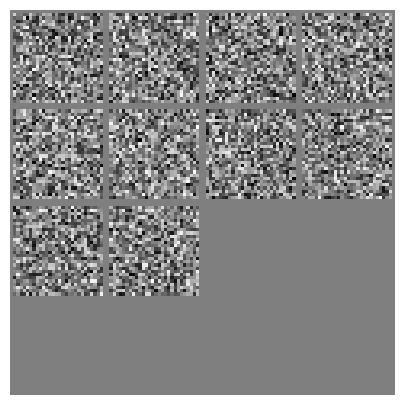

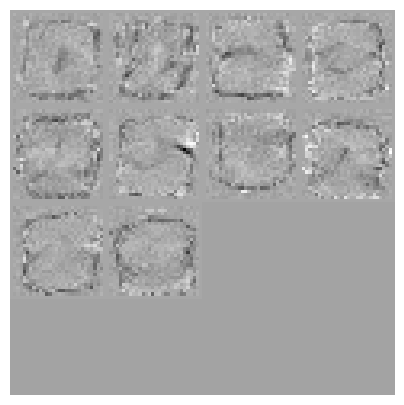

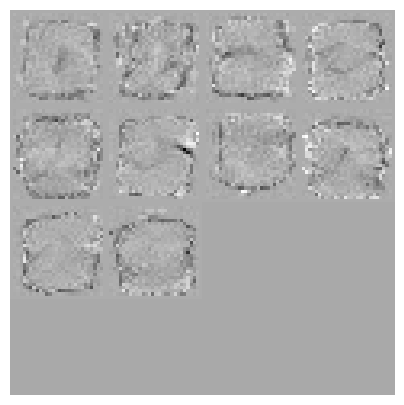

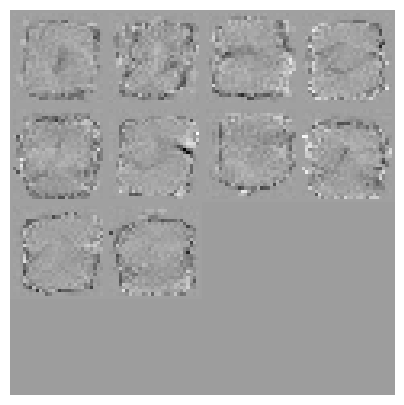

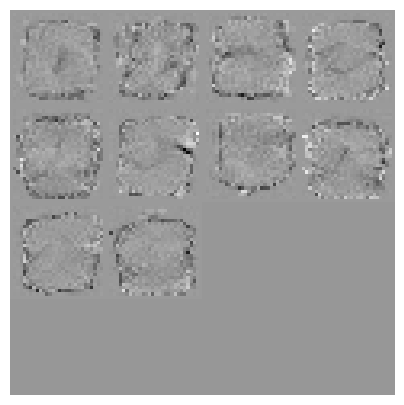

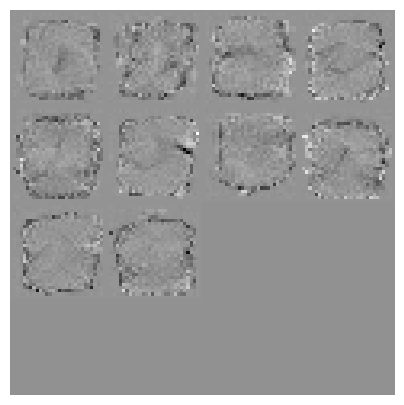

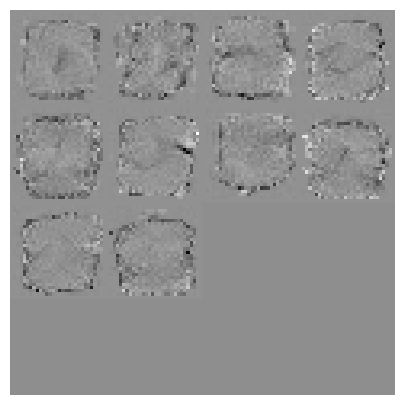

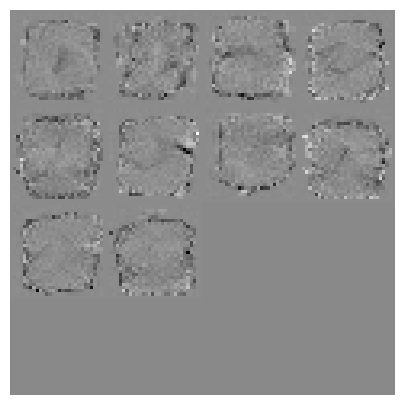

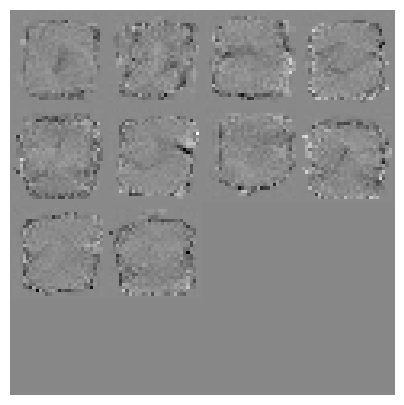

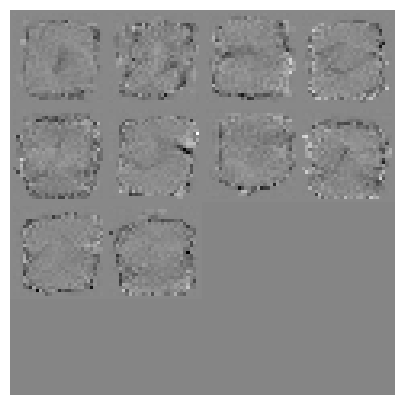

acc_test,▁▆▇▅▇▅█▇▇█▅▆▆▇▅▄▇▆▇▅▄▇▆▅▄▄▅▇█▅▇▇▇▅▇▇▅▄▅▇
acc_train,▁▆▇▇▇█▇▇██▇█▇▇▇▇▇▇█▆▇▇▇▇▇▇▇▇█▇█▇▇██████▇
loss,█▃▂▂▂▁▂▂▁▁▂▁▂▂▁▂▂▂▁▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▂
acc_test,0.88281
acc_train,0.96289
loss,1.49823


<ipython-input-19-c3d856de2607>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))


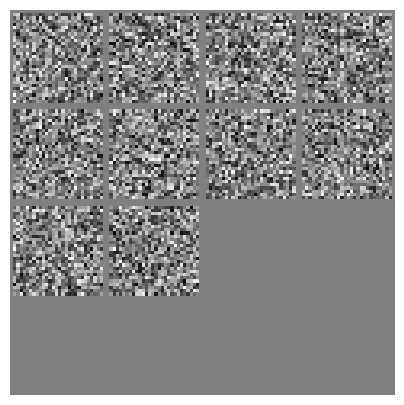

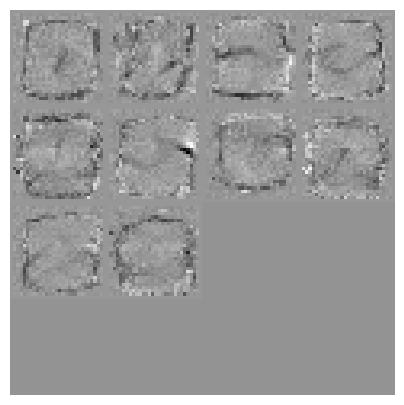

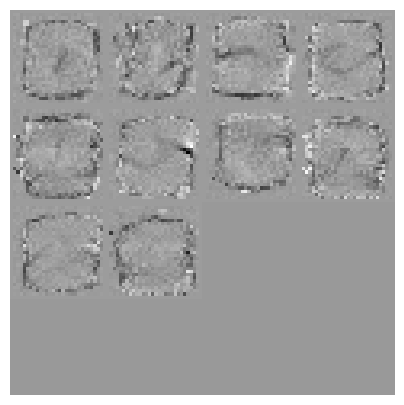

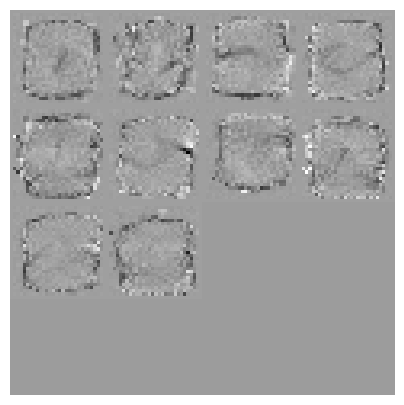

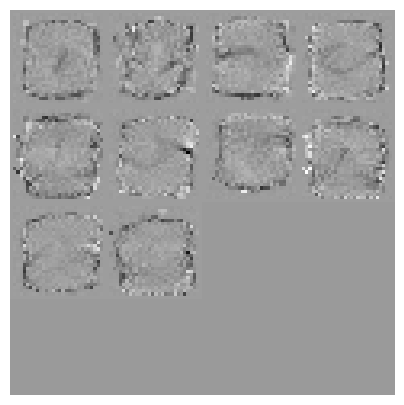

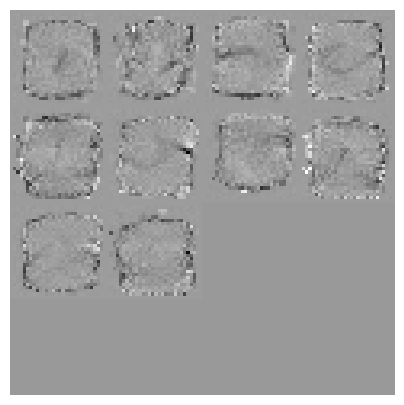

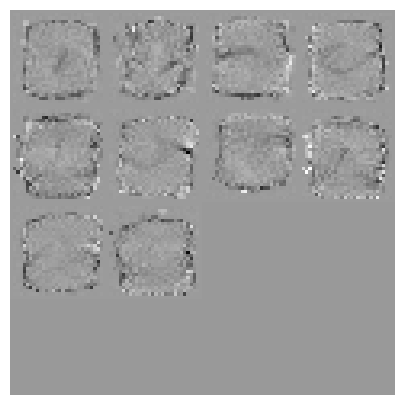

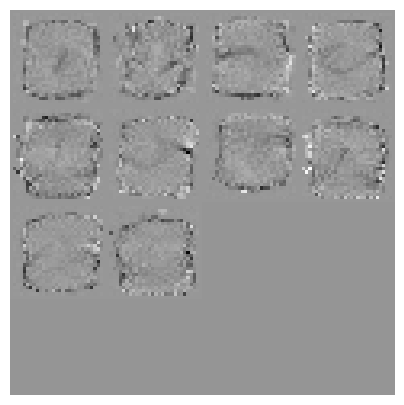

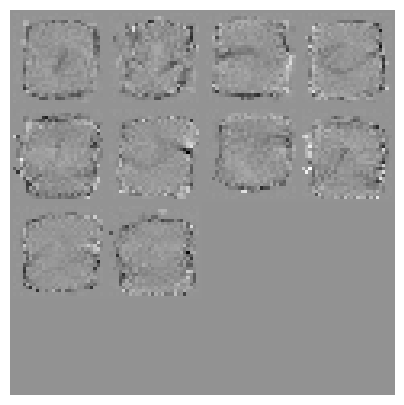

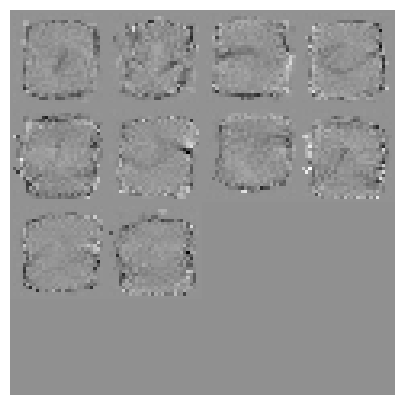

acc_test,▁█▆▆▄▁▃▂▃▃▆▅▃▃▆▃▃▆▄█▅▅▃▆▄▅▆▅▂▃▃▅▂▃▆▇▃▆▃▅
acc_train,▁▆▇▆▆▆▇▆▇█▇▇▇▇▇▇▇▆▇▇▆▇▆▇▇▇▇▆▇▇██▅▇▆▇▆▇▆▇
loss,█▃▂▃▃▃▂▃▂▁▂▂▂▂▂▂▂▃▂▂▃▂▃▂▂▂▂▂▂▂▁▁▃▂▃▂▂▂▂▂
acc_test,0.97852
acc_train,0.95215
loss,1.50883


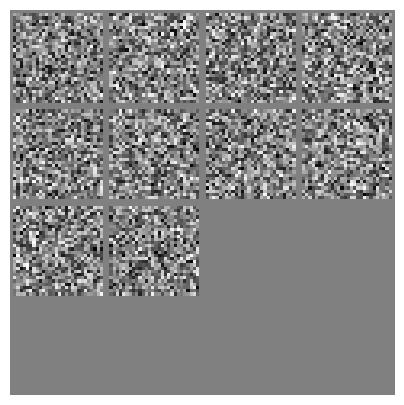

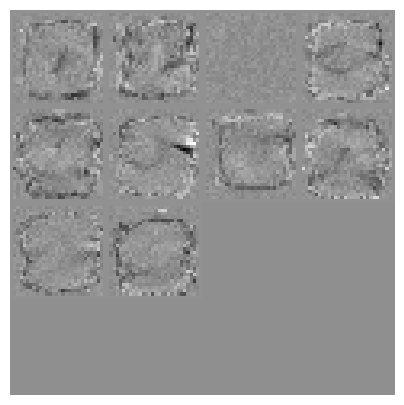

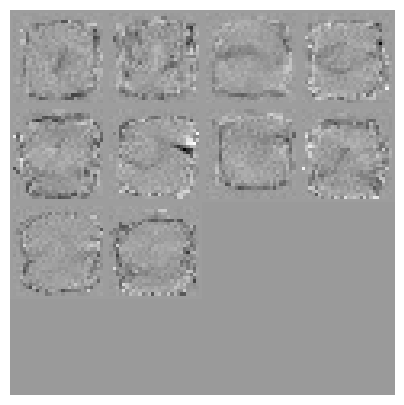

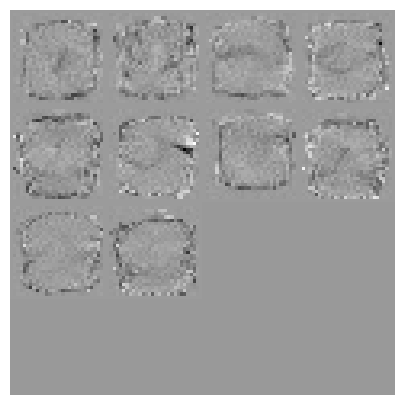

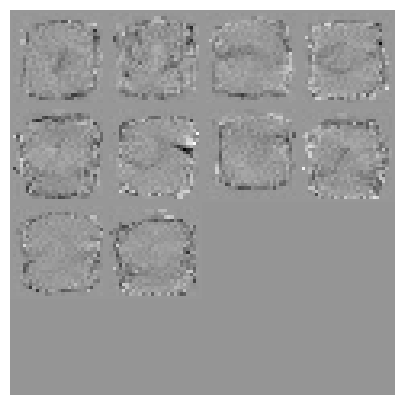

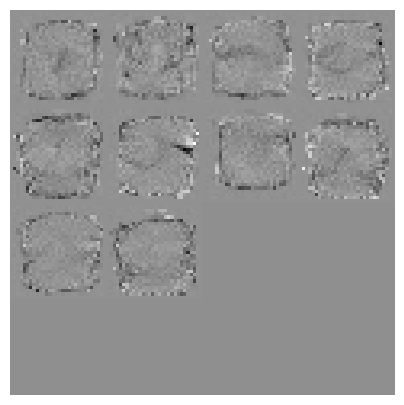

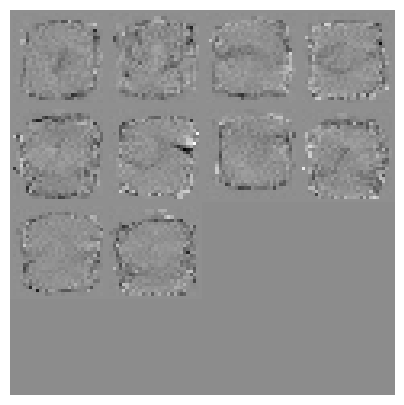

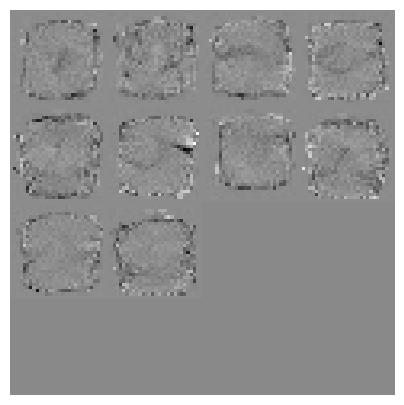

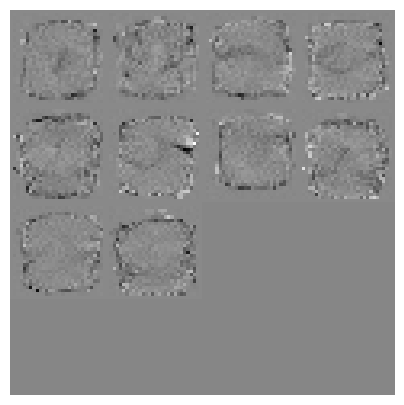

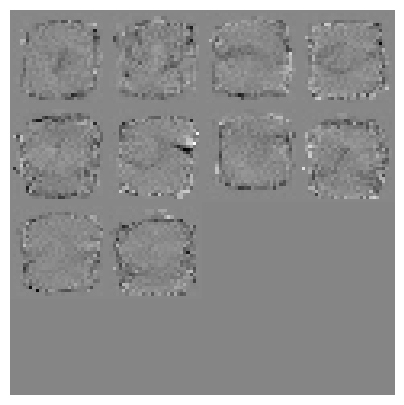

acc_test,▁▃▃▂▄▇▅▆▇▇▆█▆▆▅▆▇▇█▅█▇▇▅▇▇█▆█▇▇█▇▆▅▅▇▆▆▇
acc_train,▂▁▁▃▁█▇▇▇█▆▇▇▇█▇█▇▇▇█▅▇▇▇▇▇▇█▇▆▇█▆▇██▇▇▇
loss,▇▇█▆█▂▂▂▃▁▃▂▂▂▁▂▁▂▂▂▁▄▂▂▂▂▂▂▁▂▃▂▁▃▂▁▁▂▂▂
acc_test,0.94141
acc_train,0.96191
loss,1.49916


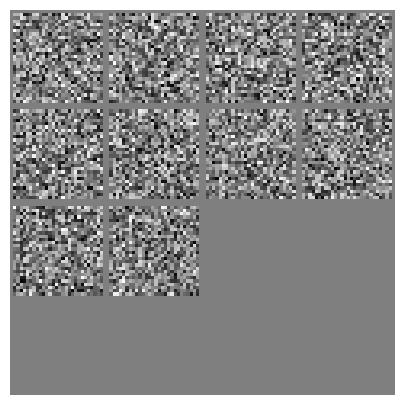

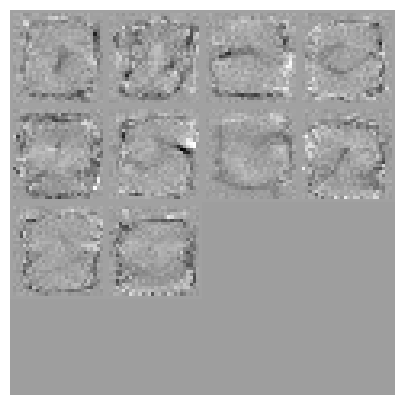

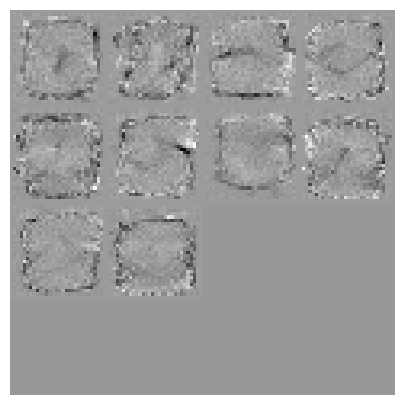

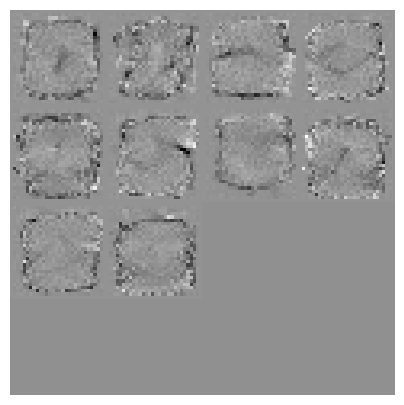

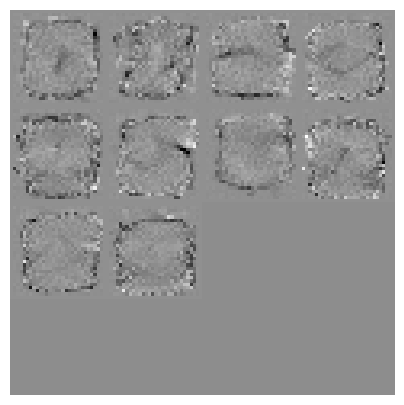

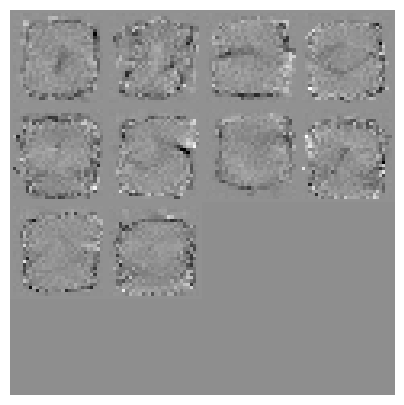

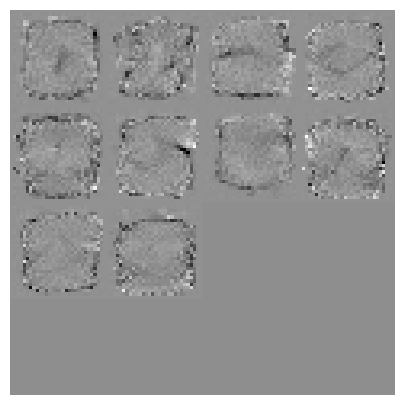

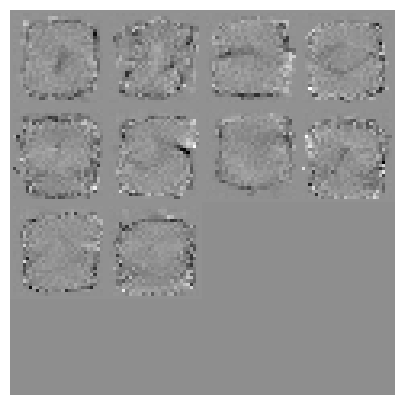

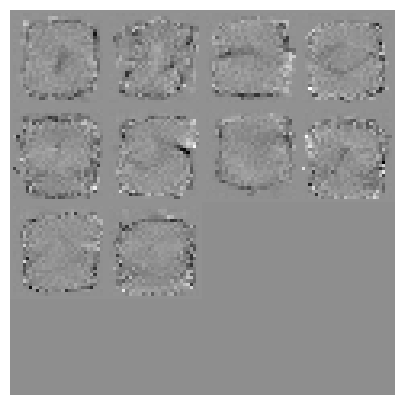

KeyboardInterrupt: 

In [65]:
for run in range(100):  # slowly starts to look more and more like actual numbers

    wb.init(project="Simple_Linear_Adam_2");
    c = wb.config

    c.L = 0.01
    c.b = 1024
    c.epochs = 100000

    w = [GPU(Truncated_Normal((784,10)))]

    optimizer = torch.optim.Adam(w, lr=c.L)

    for i in range(c.epochs):

        x,y = get_batch('train')

        loss = cross_entropy(softmax(model(x,w)),y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wb.log({"loss": loss})

        make_plots()

        if i % 10000 == 0 : montage_plot((w[0].T).reshape(10,28,28).cpu().detach().numpy())


### Autoencoder


In [67]:
def get_batch(mode):
    b = 1024
    if mode == "train":
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [68]:
X = X.reshape(X.shape[0],1,28,28)
X_test = X_test.reshape(X_test.shape[0],1,28,28)

In [69]:
import torchvision
from torch.nn.functional import *

In [70]:
X = torchvision.transforms.functional.normalize(X,0.5,0.5)
X_test = torchvision.transforms.functional.normalize(X_test,0.5,0.5)

In [71]:
def Encoder(x,w): # sets up autoencoder for encoding and decoding
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    return x

In [72]:
def Decoder(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [73]:
def Autoencoder(x,w): # uses both encoder and decoder
    return Decoder(Encoder(x,w),w)

In [74]:
num_steps = 1000
batch_size = 512
learning_rate = 1e-3

In [75]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from imageio import *
import torch
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision.models import *
from torchvision.datasets import MNIST,KMNIST,FashionMNIST
from skimage.util import montage

In [76]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [77]:
#Encode
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((10,6272)))
#Decode
w3 = GPU(randn_trunc((6272,10)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

optimizer = torch.optim.Adam(params=w, lr=learning_rate)

for i in range(num_steps):    # sets up and trains the autoencoder

    x_real,y = get_batch('train')

    x_fake = Autoencoder(x_real,w)

    loss = torch.mean((x_fake - x_real)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0: print(loss.item()) # prints loss every 100 steps to monitor progress

1.4850404262542725
0.1549374759197235
0.11738298088312149
0.1061689555644989
0.09205549210309982
0.08612282574176788
0.08303823322057724
0.08756154030561447
0.07781988382339478
0.07510156184434891


In [78]:
image_batch,y = get_batch('test')

In [79]:
image_batch_recon = Autoencoder(image_batch,w)

In [80]:
torch.mean((image_batch_recon - image_batch)**2)

tensor(0.0759, device='cuda:0', grad_fn=<MeanBackward0>)

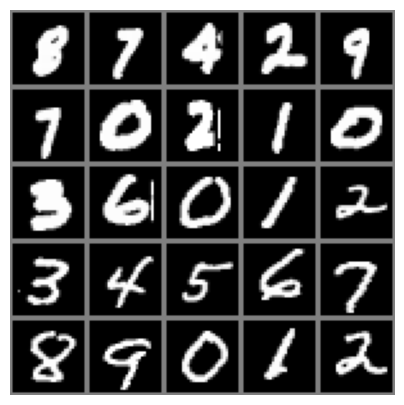

In [81]:
montage_plot(image_batch[0:25,0,:,:].cpu().detach().numpy())  # now looks like real numbers

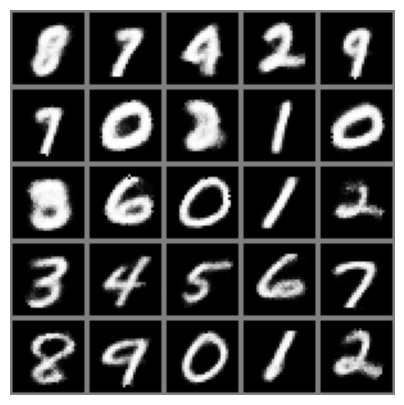

In [82]:
montage_plot(image_batch_recon[0:25,0,:,:].cpu().detach().numpy())


### Generator



In [83]:
latent_size = 64
hidden_size = 256
image_size = 784
b = 1024

In [84]:
#MNIST
# train_set = MNIST('./data', train=True, download=True)
# test_set = MNIST('./data', train=False, download=True)

#KMNIST
#train_set = KMNIST('./data', train=True, download=True)
#test_set = KMNIST('./data', train=False, download=True)

#Fashion MNIST
train_set = FashionMNIST('./data', train=True, download=True)
test_set = FashionMNIST('./data', train=False, download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9889710.59it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173637.54it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3284212.05it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7786612.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [85]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [86]:
n = 7

index = np.where(Y == n)
X = X[index]
index = np.where(Y_test == n)
X_test = X_test[index]

In [87]:
X.shape,Y.shape,X_test.shape,Y_test.shape

((6000, 1, 28, 28), (60000,), (1000, 1, 28, 28), (10000,))

In [88]:
###################################################

In [89]:
X = GPU_data(X)
X_test = GPU_data(X_test)
Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

In [90]:
x,y = get_batch('train')

In [91]:
x.shape

torch.Size([1024, 1, 28, 28])

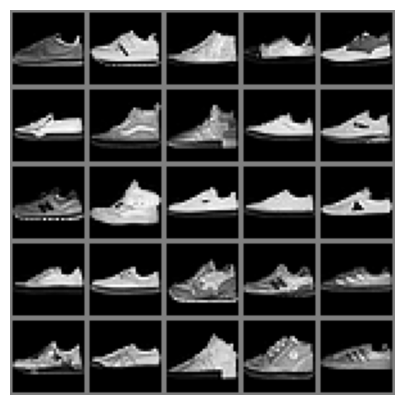

In [92]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy())  # can recreate more than just numbers

In [93]:
#Discriminator
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((1,6272)))
#Generator
w3 = GPU(randn_trunc((6272,64)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

In [94]:
def D(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    x = torch.sigmoid(x)
    return x

In [95]:
def G(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [96]:
b = 1024

In [97]:
batch_size = b

In [98]:
batch_size

1024

In [99]:
d_optimizer = torch.optim.Adam(w[0:3], lr=0.0002)
g_optimizer = torch.optim.Adam(w[3:], lr=0.0002)

real_labels = (torch.ones(batch_size, 1).cuda())
fake_labels = (torch.zeros(batch_size, 1).cuda())

In [100]:
num_epochs = 500
batches = X.shape[0]//batch_size
steps = num_epochs*batches

In [101]:
z1 = (torch.randn(steps,batch_size,latent_size).cuda())
z2 = (torch.randn(steps,batch_size,latent_size).cuda())

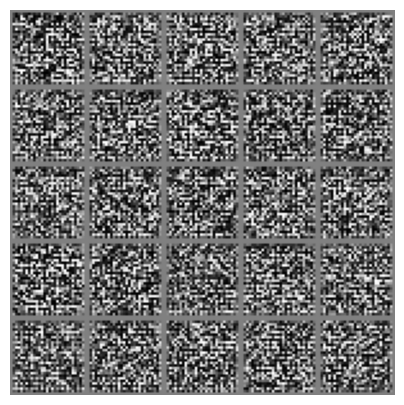

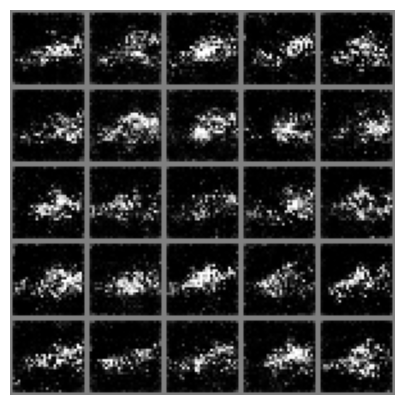

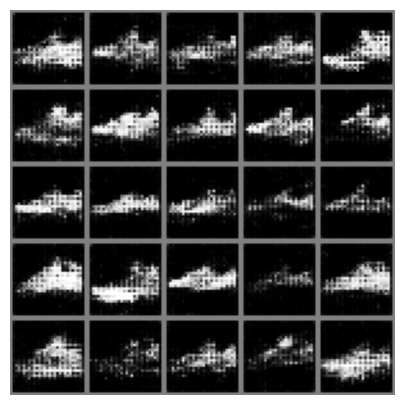

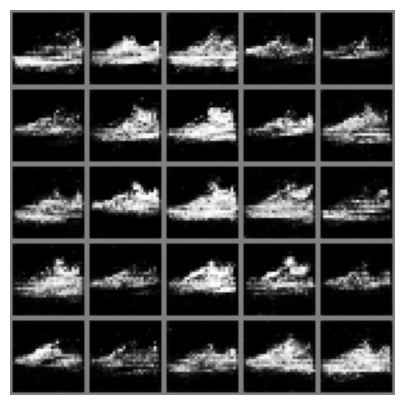

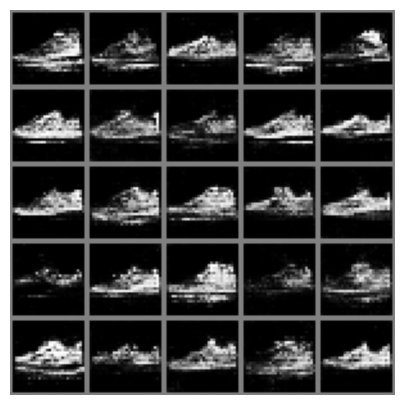

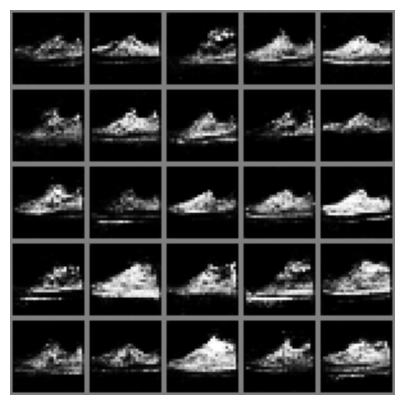

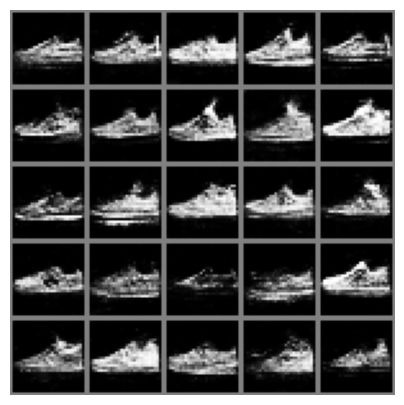

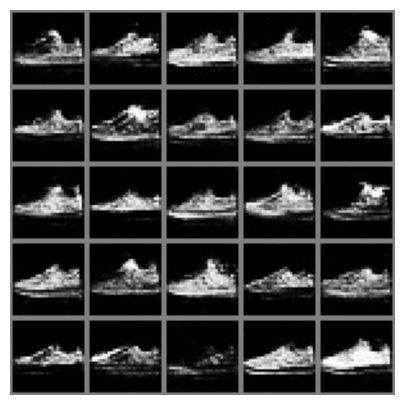

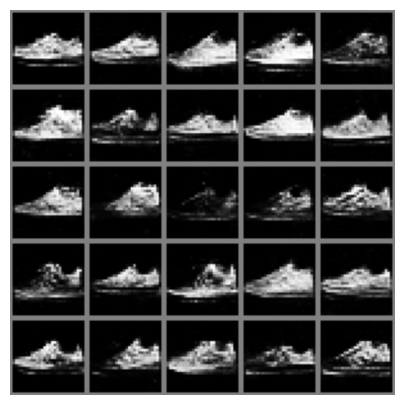

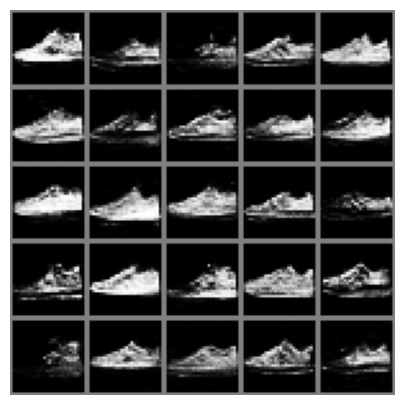

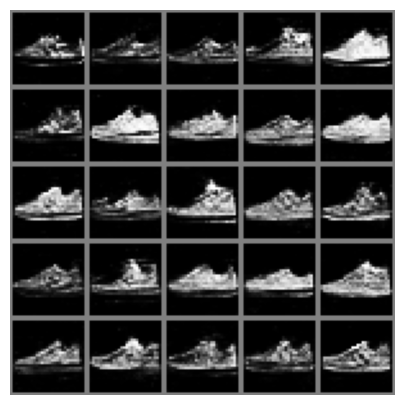

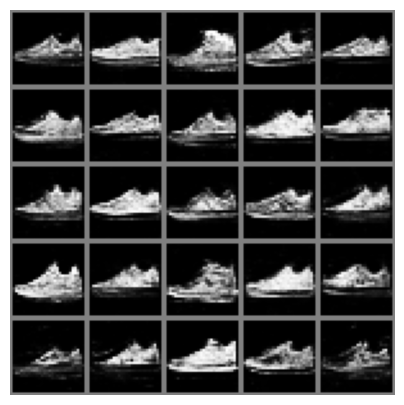

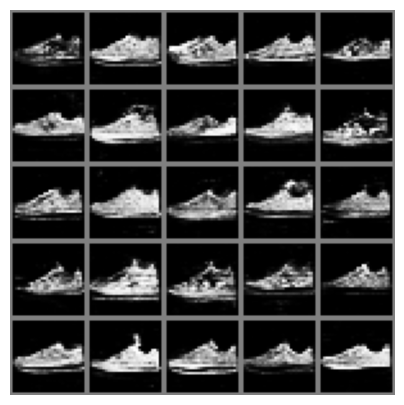

In [102]:
for i in range(steps):

    images,y = get_batch('train')

    d_loss = binary_cross_entropy(D(images,w), real_labels) + binary_cross_entropy(D(G(z1[i],w),w), fake_labels)
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    g_loss = binary_cross_entropy(D(G(z2[i],w),w), real_labels)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    if i % 200 == 0:
        out = G(z1[np.random.randint(steps)],w)
        montage_plot(out.view(batch_size,1,28,28).detach().cpu().numpy()[0:25,0,:,:])

In [103]:
z1[np.random.randint(steps)].shape

torch.Size([1024, 64])

In [104]:
noise = GPU_data(torch.randn(1,64))

<ipython-input-19-c3d856de2607>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))


In [105]:
output = G(noise,w)

In [106]:
output.shape

torch.Size([1, 1, 28, 28])

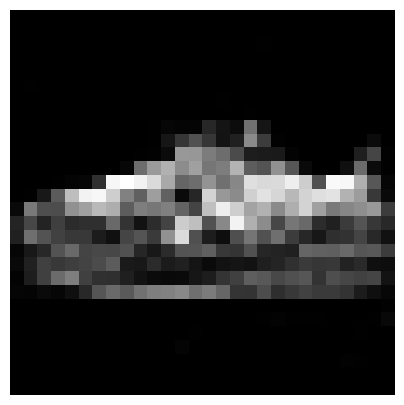

In [107]:
plot(output[0,0])